<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/FNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [0]:
import torch
import math
import pandas as pd
import torch.nn.functional as F
import numpy as np
from torch.distributions import Bernoulli
from itertools import product
import torch.nn as nn
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from scipy.signal import savgol_filter
import warnings
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid', 'seaborn-colorblind', 'seaborn-notebook'])
warnings.filterwarnings('ignore')

# utils

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
float_tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


def logitexp(logp):
    # https: // github.com / pytorch / pytorch / issues / 4007
    pos = torch.clamp(logp, min=-0.69314718056)
    neg = torch.clamp(logp, max=-0.69314718056)
    neg_val = neg - torch.log(1 - torch.exp(neg))
    pos_val = -torch.log(torch.clamp(torch.expm1(-pos), min=1e-20))
    return pos_val + neg_val


def one_hot(x, n_classes=10):
    x_onehot = float_tensor(x.size(0), n_classes).zero_()
    x_onehot.scatter_(1, x[:, None], 1)

    return x_onehot


class LogitRelaxedBernoulli(object):
    def __init__(self, logits, temperature=0.3, **kwargs):
        self.logits = logits
        self.temperature = temperature

    def rsample(self):
        eps = torch.clamp(torch.rand(self.logits.size(), dtype=self.logits.dtype, device=self.logits.device),
                          min=1e-6, max=1-1e-6)
        y = (self.logits + torch.log(eps) - torch.log(1. - eps)) / self.temperature
        return y

    def log_prob(self, value):
        return math.log(self.temperature) - self.temperature * value + self.logits \
               - 2 * F.softplus(-self.temperature * value + self.logits)


class Normal(object):
    def __init__(self, means, logscales, **kwargs):
        self.means = means
        self.logscales = logscales

    def log_prob(self, value):
        log_prob = torch.pow(value - self.means, 2)
        log_prob *= - (1 / (2. * self.logscales.mul(2.).exp()))
        log_prob -= self.logscales + .5 * math.log(2. * math.pi)
        return log_prob

    def sample(self, **kwargs):
        eps = torch.normal(float_tensor(self.means.size()).zero_(), float_tensor(self.means.size()).fill_(1))
        return self.means + self.logscales.exp() * eps

    def rsample(self, **kwargs):
        return self.sample(**kwargs)


def order_z(z):
    # scalar ordering function
    if z.size(1) == 1:
        return z
    log_cdf = torch.sum(torch.log(.5 + .5 * torch.erf(z / math.sqrt(2))), dim=1, keepdim=True)
    return log_cdf


def sample_DAG(Z, g, training=True, temperature=0.3):
    # get the indices of an upper triangular adjacency matrix that represents the DAG
    idx_utr = np.triu_indices(Z.size(0), 1)

    # get the ordering
    ordering = order_z(Z)
    # sort the latents according to the ordering
    sort_idx = torch.sort(torch.squeeze(ordering), 0)[1]
    Y = Z[sort_idx, :]
    # form the latent pairs for the edges
    Z_pairs = torch.cat([Y[idx_utr[0]], Y[idx_utr[1]]], 1)
    # get the logits for the edges in the DAG
    logits = g(Z_pairs)

    if training:
        p_edges = LogitRelaxedBernoulli(logits=logits, temperature=temperature)
        G = torch.sigmoid(p_edges.rsample())
    else:
        p_edges = Bernoulli(logits=logits)
        G = p_edges.sample()

    # embed the upper triangular to the adjacency matrix
    unsorted_G = float_tensor(Z.size(0), Z.size(0)).zero_()
    unsorted_G[idx_utr[0], idx_utr[1]] = G.squeeze()
    # unsort the dag to conform to the data order
    original_idx = torch.sort(sort_idx)[1]
    unsorted_G = unsorted_G[original_idx, :][:, original_idx]

    return unsorted_G


def sample_bipartite(Z1, Z2, g, training=True, temperature=0.3):
    indices = []
    for element in product(range(Z1.size(0)), range(Z2.size(0))):
        indices.append(element)
    indices = np.array(indices)
    Z_pairs = torch.cat([Z1[indices[:, 0]], Z2[indices[:, 1]]], 1)

    logits = g(Z_pairs)
    if training:
        p_edges = LogitRelaxedBernoulli(logits=logits, temperature=temperature)
        A_vals = torch.sigmoid(p_edges.rsample())
    else:
        p_edges = Bernoulli(logits=logits)
        A_vals = p_edges.sample()

    # embed the values to the adjacency matrix
    A = float_tensor(Z1.size(0), Z2.size(0)).zero_()
    A[indices[:, 0], indices[:, 1]] = A_vals.squeeze()

    return A


class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        assert len(x.shape) > 1

        return x.view(x.shape[0], -1)


# model

In [0]:
class RegressionFNP(nn.Module):
    """
    Functional Neural Process for regression
    """
    def __init__(self, dim_x=1, dim_y=1, dim_h=50, transf_y=None, n_layers=1, use_plus=True, num_M=100,
                 dim_u=1, dim_z=1, fb_z=0.):
        '''
        :param dim_x: Dimensionality of the input
        :param dim_y: Dimensionality of the output
        :param dim_h: Dimensionality of the hidden layers
        :param transf_y: Transformation of the output (e.g. standardization)
        :param n_layers: How many hidden layers to use
        :param use_plus: Whether to use the FNP+
        :param num_M: How many points exist in the training set that are not part of the reference set
        :param dim_u: Dimensionality of the latents in the embedding space
        :param dim_z: Dimensionality of the  latents that summarize the parents
        :param fb_z: How many free bits do we allow for the latent variable z
        '''
        super(RegressionFNP, self).__init__()

        self.num_M = num_M
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_h = dim_h
        self.dim_u = dim_u
        self.dim_z = dim_z
        self.use_plus = use_plus
        self.fb_z = fb_z
        self.transf_y = transf_y
        # normalizes the graph such that inner products correspond to averages of the parents
        self.norm_graph = lambda x: x / (torch.sum(x, 1, keepdim=True) + 1e-8)

        self.register_buffer('lambda_z', float_tensor(1).fill_(1e-8))

        # function that assigns the edge probabilities in the graph
        self.pairwise_g_logscale = nn.Parameter(float_tensor(1).fill_(math.log(math.sqrt(self.dim_u))))
        self.pairwise_g = lambda x: logitexp(-.5 * torch.sum(torch.pow(x[:, self.dim_u:] - x[:, 0:self.dim_u], 2), 1,
                                                             keepdim=True) / self.pairwise_g_logscale.exp()).view(x.size(0), 1)
        # transformation of the input
        init = [nn.Linear(dim_x, self.dim_h), nn.ReLU()]
        for i in range(n_layers - 1):
            init += [nn.Linear(self.dim_h, self.dim_h), nn.ReLU()]
        self.cond_trans = nn.Sequential(*init)
        # p(u|x)
        self.p_u = nn.Linear(self.dim_h, 2 * self.dim_u)
        # q(z|x)
        self.q_z = nn.Linear(self.dim_h, 2 * self.dim_z)
        # for p(z|A, XR, yR)
        self.trans_cond_y = nn.Linear(self.dim_y, 2 * self.dim_z)

        # p(y|z) or p(y|z, u)
        self.output = nn.Sequential(nn.Linear(self.dim_z if not self.use_plus else self.dim_z + self.dim_u, self.dim_h),
                                    nn.ReLU(), nn.Linear(self.dim_h, 2 * dim_y))

    def forward(self, XR, yR, XM, yM, kl_anneal=1.):
        X_all = torch.cat([XR, XM], dim=0)
        H_all = self.cond_trans(X_all)

        # get U
        pu_mean_all, pu_logscale_all = torch.split(self.p_u(H_all), self.dim_u, dim=1)
        pu = Normal(pu_mean_all, pu_logscale_all)
        u = pu.rsample()

        # get G
        G = sample_DAG(u[0:XR.size(0)], self.pairwise_g, training=self.training)

        # get A
        A = sample_bipartite(u[XR.size(0):], u[0:XR.size(0)], self.pairwise_g, training=self.training)

        # get Z
        qz_mean_all, qz_logscale_all = torch.split(self.q_z(H_all), self.dim_z, 1)
        qz = Normal(qz_mean_all, qz_logscale_all)
        z = qz.rsample()

        cond_y_mean, cond_y_logscale = torch.split(self.trans_cond_y(yR), self.dim_z, 1)
        pz_mean_all = torch.mm(self.norm_graph(torch.cat([G, A], dim=0)), cond_y_mean + qz_mean_all[0:XR.size(0)])
        pz_logscale_all = torch.mm(self.norm_graph(torch.cat([G, A], dim=0)), cond_y_logscale + qz_logscale_all[0:XR.size(0)])

        pz = Normal(pz_mean_all, pz_logscale_all)

        pqz_all = pz.log_prob(z) - qz.log_prob(z)

        # apply free bits for the latent z
        if self.fb_z > 0:
            log_qpz = - torch.sum(pqz_all)

            if self.training:
                if log_qpz.item() > self.fb_z * z.size(0) * z.size(1) * (1 + 0.05):
                    self.lambda_z = torch.clamp(self.lambda_z * (1 + 0.1), min=1e-8, max=1.)
                elif log_qpz.item() < self.fb_z * z.size(0) * z.size(1):
                    self.lambda_z = torch.clamp(self.lambda_z * (1 - 0.1), min=1e-8, max=1.)

            log_pqz_R = self.lambda_z * torch.sum(pqz_all[0:XR.size(0)])
            log_pqz_M = self.lambda_z * torch.sum(pqz_all[XR.size(0):])

        else:
            log_pqz_R = torch.sum(pqz_all[0:XR.size(0)])
            log_pqz_M = torch.sum(pqz_all[XR.size(0):])

        final_rep = z if not self.use_plus else torch.cat([z, u], dim=1)

        mean_y, logstd_y = torch.split(self.output(final_rep), 1, dim=1)
        logstd_y = torch.log(0.1 + 0.9 * F.softplus(logstd_y))

        mean_yR, mean_yM = mean_y[0:XR.size(0)], mean_y[XR.size(0):]
        logstd_yR, logstd_yM = logstd_y[0:XR.size(0)], logstd_y[XR.size(0):]

        # logp(R)
        pyR = Normal(mean_yR, logstd_yR)
        log_pyR = torch.sum(pyR.log_prob(yR))

        # logp(M|S)
        pyM = Normal(mean_yM, logstd_yM)
        log_pyM = torch.sum(pyM.log_prob(yM))

        obj_R = (log_pyR + log_pqz_R) / float(self.num_M)
        obj_M = (log_pyM + log_pqz_M) / float(XM.size(0))

        obj = obj_R + obj_M

        loss = - obj

        return loss

    def predict(self, x_new, XR, yR, sample=True):

        H_all = self.cond_trans(torch.cat([XR, x_new], 0))

        # get U
        pu_mean_all, pu_logscale_all = torch.split(self.p_u(H_all), self.dim_u, dim=1)
        pu = Normal(pu_mean_all, pu_logscale_all)
        u = pu.rsample()

        A = sample_bipartite(u[XR.size(0):], u[0:XR.size(0)], self.pairwise_g, training=False)

        pz_mean_all, pz_logscale_all = torch.split(self.q_z(H_all[0:XR.size(0)]), self.dim_z, 1)
        cond_y_mean, cond_y_logscale = torch.split(self.trans_cond_y(yR), self.dim_z, 1)
        pz_mean_all = torch.mm(self.norm_graph(A), cond_y_mean + pz_mean_all)
        pz_logscale_all = torch.mm(self.norm_graph(A), cond_y_logscale + pz_logscale_all)
        pz = Normal(pz_mean_all, pz_logscale_all)

        z = pz.rsample()
        final_rep = z if not self.use_plus else torch.cat([z, u[XR.size(0):]], dim=1)

        mean_y, logstd_y = torch.split(self.output(final_rep), 1, dim=1)
        logstd_y = torch.log(0.1 + 0.9 * F.softplus(logstd_y))

        init_y = Normal(mean_y, logstd_y)
        if sample:
            y_new_i = init_y.sample()
        else:
            y_new_i = mean_y

        y_pred = y_new_i

        if self.transf_y is not None:
            if torch.cuda.is_available():
                y_pred = self.transf_y.inverse_transform(y_pred.cpu().data.numpy())
            else:
                y_pred = self.transf_y.inverse_transform(y_pred.data.numpy())

        return y_pred

# data processing

In [0]:
filename = "/content/refcat_yufengzhu.csv"
df = pd.read_csv(filename)

gaia_selected = df.loc[(df['dplx'] <= 0.1) 
                       & (df['plx'] <= 5) & (df['plx'] > 0 )]
print(gaia_selected.shape)
gaia_selected.head()

(66619, 45)


,objid,RA,Dec,plx,dplx,pmra,dpmra,pmdec,dpmdec,Gaia,dGaia,BP,dBP,RP,dRP,Teff,AGaia,dupvar,Ag,rp1,r1,r10,g,dg,gchi,gcontrib,r,dr,rchi,rcontrib,i,di,ichi,icontrib,z,dz,zchi,zcontrib,nstat,J,dJ,H,dH,K,dK
4,106500066069434848,6.606943,-1.246314,0.85,0.04,9.70,0.07,1.040000,0.05,15.084000,0.001,15.456000,0.002,14.551,0.001,5411,0.242,2,0.069,99.900002,99.900002,99.900002,15.479000,0.007,1.39,63,15.043,0.007,1.97,63,14.891,0.008,4.95,63,14.855,0.008,0.16,15,0,13.967,0.023,13.967,0.025,13.564,0.046
8,106500151256391374,15.125640,-1.249210,1.43,0.06,-7.39,0.10,-56.639999,0.07,15.927000,0.001,16.469999,0.004,15.237,0.003,4909,0.139,2,0.113,99.900002,99.900002,99.900002,16.584999,0.009,3.50,125,15.886,0.008,1.17,125,15.608,0.009,1.78,61,15.479,0.009,0.33,13,0,0.000,0.000,0.000,0.000,0.000,0.000
13,106500285017587007,28.501759,-1.244515,1.77,0.06,-2.89,0.07,-0.220000,0.07,15.034000,0.001,15.523000,0.003,14.405,0.001,4988,0.093,2,0.080,99.900002,99.900002,99.900002,15.600000,0.007,0.42,63,14.995,0.007,1.01,63,14.752,0.007,2.54,63,14.657,0.008,1.31,15,0,13.642,0.026,13.642,0.027,13.074,0.028
16,106500311137163219,31.113717,-1.247672,2.25,0.08,-14.99,0.15,-13.810000,0.11,16.188999,0.001,17.101000,0.007,15.250,0.002,4012,0.358,2,0.081,24.400000,99.900002,99.900002,17.443001,0.010,0.18,45,16.253,0.009,0.62,45,15.625,0.009,8.08,45,15.347,0.010,0.24,13,0,14.151,0.023,14.151,0.027,13.197,0.032
20,106500342975680820,34.297569,-1.249672,1.42,0.05,-6.84,0.10,-8.180000,0.08,15.788000,0.001,16.332001,0.003,15.113,0.002,4933,0.105,2,0.102,99.900002,99.900002,99.900002,16.441000,0.009,7.96,127,15.742,0.008,3.10,127,15.462,0.008,2.10,127,15.351,0.008,0.33,15,0,14.279,0.027,14.279,0.032,13.741,0.041


In [0]:
# using {ra, dec, mag, wavelength}
def Normalization_old(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

g_mag = gaia_selected.loc[:, ['RA', 'Dec','Gaia', 'plx']]
g_mag = g_mag.rename(columns={'Gaia':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, ['RA', 'Dec','BP', 'plx']]
bp_mag = bp_mag.rename(columns={'BP':"mag"})
bp_mag = bp_mag.dropna()

rp_mag = gaia_selected.loc[:, ['RA', 'Dec','RP', 'plx']]
rp_mag = rp_mag.rename(columns={'RP':"mag"})
rp_mag = rp_mag.dropna()

i_mag = gaia_selected.loc[:, ['RA', 'Dec','i', 'plx']]
i_mag = i_mag.rename(columns={'i':"mag"})
i_mag = i_mag.dropna()

gg_mag = gaia_selected.loc[:, ['RA', 'Dec','g', 'plx']]
gg_mag = gg_mag.rename(columns={'g':"mag"})
gg_mag = gg_mag.dropna()

r_mag = gaia_selected.loc[:, ['RA', 'Dec','r', 'plx']]
r_mag = r_mag.rename(columns={'r':"mag"})
r_mag = r_mag.dropna()

z_mag = gaia_selected.loc[:, ['RA', 'Dec','z', 'plx']]
z_mag = z_mag.rename(columns={'z':"mag"})
z_mag = z_mag.dropna()

g_mag ['wavelength'] = 5858
bp_mag ['wavelength'] = 5044
rp_mag ['wavelength'] = 7692
gg_mag['wavelength'] = 4810
r_mag['wavelength'] = 7503
i_mag['wavelength'] = 6156
z_mag['wavelength'] = 8668

new_df = g_mag.append(bp_mag)
new_df = new_df.append(rp_mag)
new_df = new_df.append(gg_mag)
new_df = new_df.append(r_mag)
new_df = new_df.append(i_mag)
new_df = new_df.append(z_mag)

#split into x_y
x_df = new_df.loc[:,['RA', 'Dec' , 'mag', 'wavelength']]
y_df = new_df.loc[:,['plx']]

x_df = Normalization_old(np.array(x_df))
y_df = Normalization_old(np.array(y_df))

#split into train and validation
ratio = 0.97 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y =np.array(train_y)

print(train_norm_x.shape)
print(test_norm_x.shape)

(452337, 4)
(13996, 4)


In [0]:
new_df = gaia_selected.loc[:, ['RA', 'Dec','Gaia','BP','RP','g','i','r','z','plx']]

#split into x_y
x_df = new_df.loc[:,['RA', 'Dec','Gaia','BP','RP','g','i','r','z']]
y_df = new_df.loc[:,['plx']]

x_df = Normalization_old(np.array(x_df))
y_df = Normalization_old(np.array(y_df))

#split into train and validation
ratio = 0.90 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y =np.array(train_y)

print(train_norm_x.shape)
print(test_norm_x.shape)

(59961, 9)
(6658, 9)


In [0]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/data.csv')

def Normalization_old(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

def numerical_value(string):
    if string[-1]=='M':
        return (float(string[1:-1])*1000000)
    if string[-1]=='K':
        return (float(string[1:-1])*1000)

df['Value'] = df['Value'].apply(lambda x: numerical_value(x))

df['ShortPassing'].fillna(df['ShortPassing'].mean(), inplace = True)
df['Volleys'].fillna(df['Volleys'].mean(), inplace = True)
df['Value'].fillna(df['Value'].mean(), inplace = True)
df['Dribbling'].fillna(df['Dribbling'].mean(), inplace = True)
df['Curve'].fillna(df['Curve'].mean(), inplace = True)
df['FKAccuracy'].fillna(df['FKAccuracy'], inplace = True)
df['LongPassing'].fillna(df['LongPassing'].mean(), inplace = True)
df['BallControl'].fillna(df['BallControl'].mean(), inplace = True)
df['HeadingAccuracy'].fillna(df['HeadingAccuracy'].mean(), inplace = True)
df['Finishing'].fillna(df['Finishing'].mean(), inplace = True)
df['Crossing'].fillna(df['Crossing'].mean(), inplace = True)
df['Skill Moves'].fillna(df['Skill Moves'].median(), inplace = True)
df['Weak Foot'].fillna(3, inplace = True)
df['Preferred Foot'].fillna('Right', inplace = True)
df['International Reputation'].fillna(1, inplace = True)

features_numerical = ['Potential','Age','Weak Foot','Overall','Special', 'Skill Moves','International Reputation','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
X = df[features_numerical]
Y = df['Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=10)
X_test = X_test.reset_index()
X_test = X_test.fillna(X_test.mean())
X_train = X_train.reset_index()
X_train = X_train.fillna(X_train.mean())

y_train = np.array(Y_train).reshape(Y_train.shape[0],-1)
y_test = np.array(Y_test).reshape(Y_test.shape[0],-1)

train_norm_x = Normalization_old(np.array(X_train))
#train_norm_y = y_train
train_norm_y = Normalization_old(np.array(y_train))
test_norm_x = Normalization_old(np.array(X_test))
#test_norm_y = y_test
test_norm_y = Normalization_old(np.array(y_test))

In [0]:
print(train_norm_x.shape)
print(train_norm_y.shape)
print(train_norm_y)

(12744, 41)
(12744, 1)
[[-0.01462682]
 [-0.0185052 ]
 [ 0.0114445 ]
 ...
 [-0.02044439]
 [-0.01096391]
 [-0.02061676]]


# main

Epoch 0/100, loss: 3.268


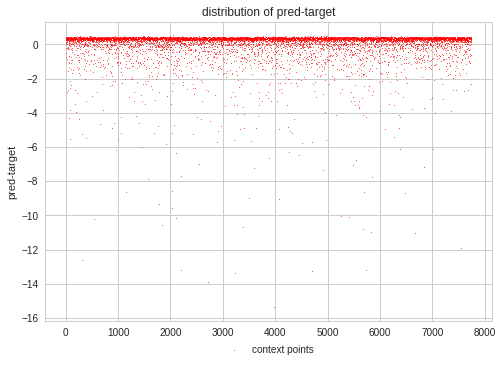

[[-0.03064334]
 [ 0.01167724]
 [ 0.00343516]
 ...
 [-0.00274443]
 [ 0.01778035]
 [-0.0767087 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 1/100, loss: 3.267


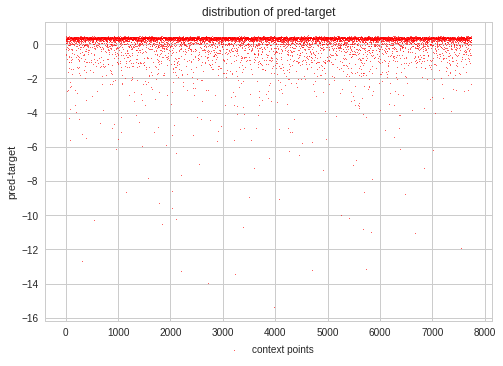

[[-0.08695556]
 [-0.0982916 ]
 [-0.01874143]
 ...
 [ 0.00728147]
 [-0.02696045]
 [ 0.03173288]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 2/100, loss: 3.327


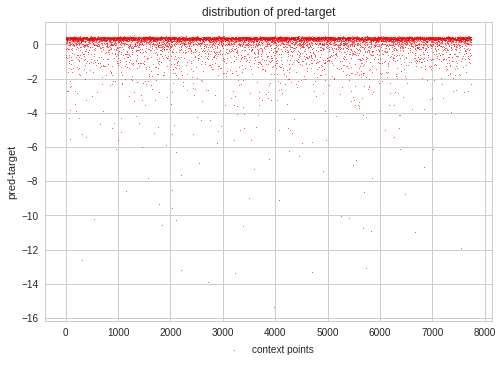

[[-0.00011393]
 [ 0.00889569]
 [-0.04436609]
 ...
 [-0.00518476]
 [-0.0052901 ]
 [ 0.00312437]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 3/100, loss: 3.227


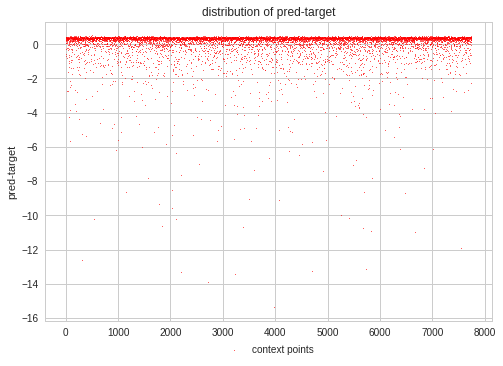

[[-0.02836454]
 [-0.03523616]
 [-0.0597371 ]
 ...
 [-0.01888394]
 [ 0.0036789 ]
 [-0.02325656]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 4/100, loss: 3.147


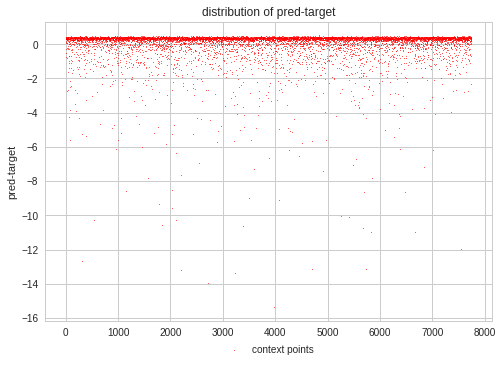

[[ 0.0299499 ]
 [ 0.01688243]
 [-0.01777269]
 ...
 [-0.06947865]
 [-0.02906894]
 [-0.015031  ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 5/100, loss: 3.275


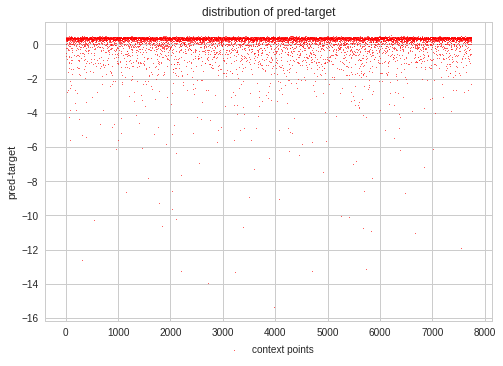

[[-0.0414292 ]
 [-0.04526732]
 [ 0.01880035]
 ...
 [ 0.00138964]
 [-0.00785131]
 [-0.00847486]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 6/100, loss: 3.033


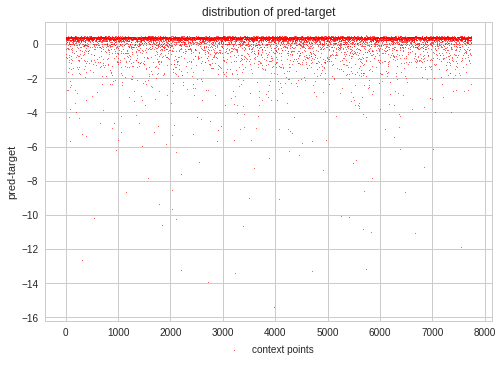

[[-0.01456837]
 [ 0.03724564]
 [-0.02939866]
 ...
 [-0.02968314]
 [-0.03498698]
 [-0.01242857]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 7/100, loss: 3.074


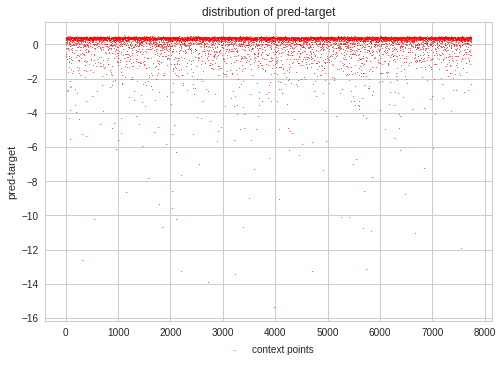

[[ 0.09340022]
 [ 0.02106177]
 [ 0.01026217]
 ...
 [-0.04554676]
 [-0.05310832]
 [-0.01845832]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 8/100, loss: 3.058


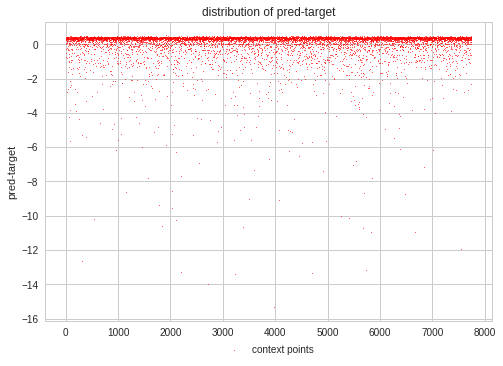

[[-0.00560723]
 [-0.02248033]
 [-0.03200493]
 ...
 [ 0.00593235]
 [-0.00176351]
 [-0.00484156]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 9/100, loss: 2.952


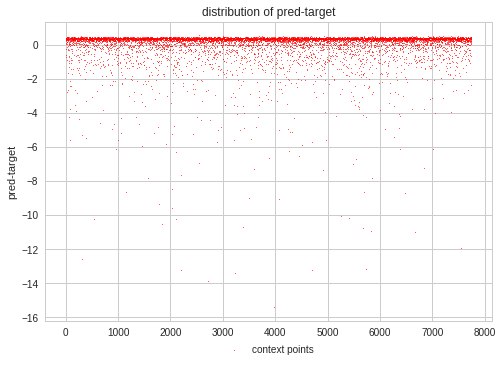

[[ 3.0392502e-02]
 [-8.2439210e-06]
 [-4.1498799e-02]
 ...
 [-3.2533064e-02]
 [ 3.0533871e-02]
 [-8.1642251e-03]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 10/100, loss: 3.009


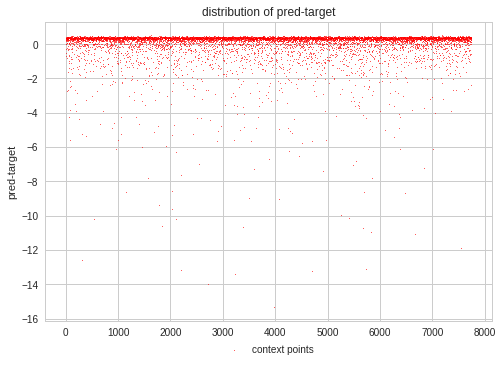

[[-0.05853219]
 [-0.03727479]
 [-0.03872021]
 ...
 [-0.00161492]
 [-0.00982885]
 [-0.00538302]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 11/100, loss: 2.923


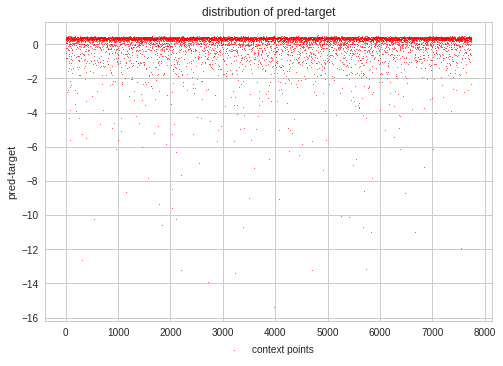

[[ 0.00293253]
 [-0.03491607]
 [ 0.0069938 ]
 ...
 [ 0.00016656]
 [ 0.00122684]
 [ 0.03253051]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 12/100, loss: 2.864


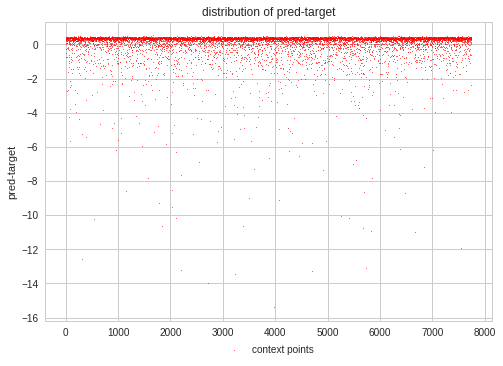

[[-0.03262593]
 [-0.02834856]
 [-0.03518993]
 ...
 [ 0.00373299]
 [ 0.00865785]
 [ 0.00188707]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 13/100, loss: 2.872


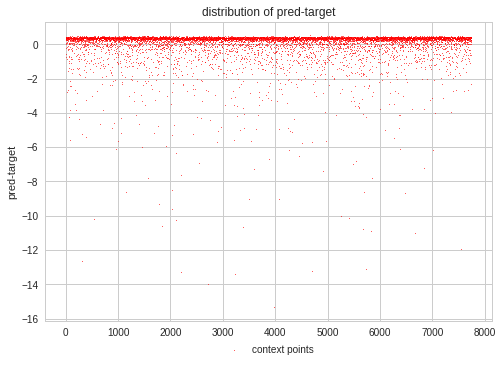

[[ 0.00713484]
 [-0.01288277]
 [ 0.01688129]
 ...
 [-0.01142524]
 [-0.02030186]
 [ 0.0184925 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 14/100, loss: 2.840


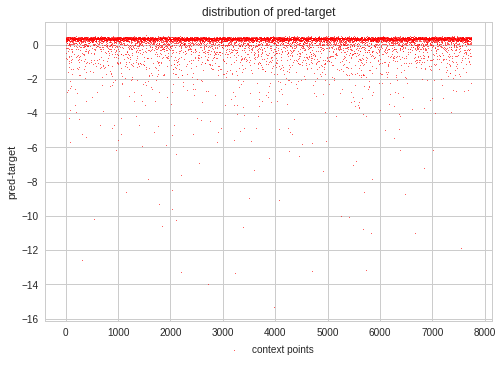

[[-0.03448216]
 [-0.07182266]
 [ 0.01574019]
 ...
 [ 0.00118078]
 [-0.03588534]
 [-0.03535309]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 15/100, loss: 2.832


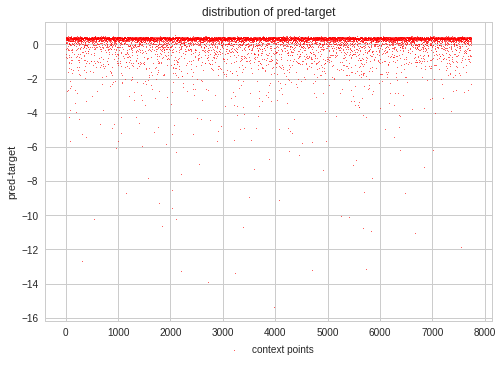

[[-0.04804688]
 [-0.01019435]
 [-0.01351947]
 ...
 [-0.02068251]
 [-0.03244638]
 [-0.02015649]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 16/100, loss: 2.779


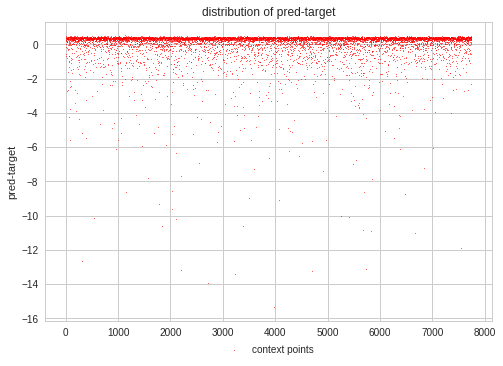

[[-0.06096015]
 [ 0.00125678]
 [ 0.05633553]
 ...
 [-0.01490754]
 [ 0.01396672]
 [ 0.05993402]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 17/100, loss: 2.762


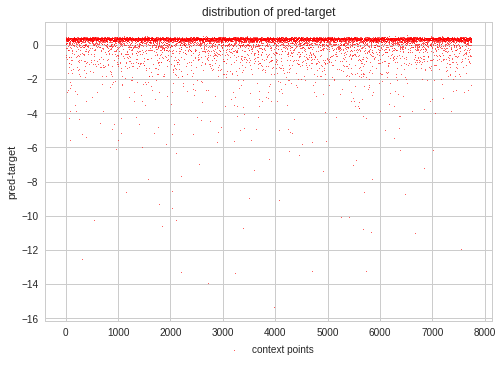

[[-0.05562946]
 [-0.01090269]
 [ 0.03160914]
 ...
 [-0.04895809]
 [ 0.00274053]
 [-0.01204852]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 18/100, loss: 2.745


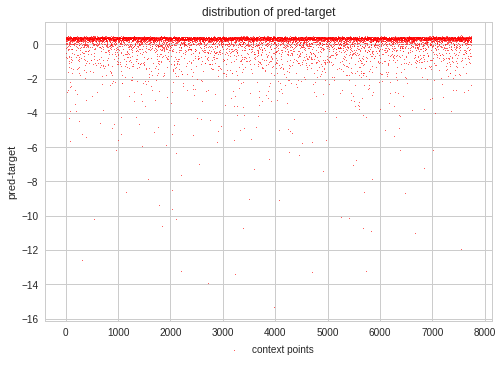

[[ 0.03937428]
 [ 0.01087725]
 [ 0.02714938]
 ...
 [-0.02350374]
 [ 0.04841772]
 [ 0.00771285]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 19/100, loss: 2.796


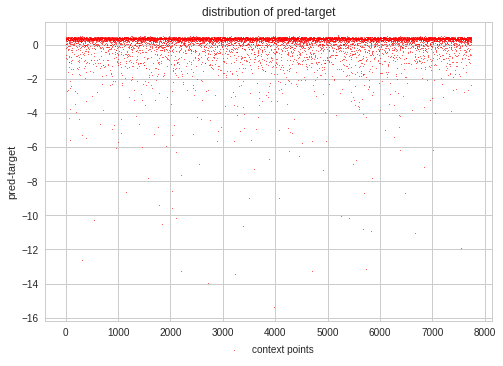

[[ 0.01166477]
 [-0.02641615]
 [ 0.01656212]
 ...
 [-0.08576517]
 [-0.09082249]
 [ 0.02219509]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 20/100, loss: 2.764


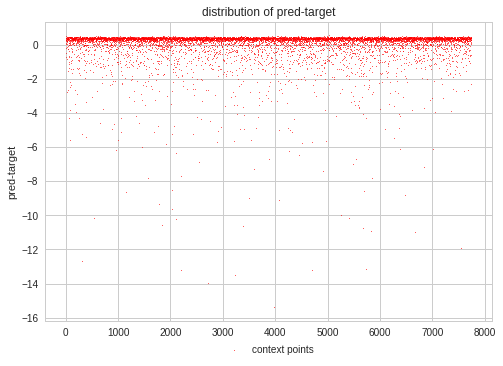

[[-0.03292111]
 [-0.01089139]
 [ 0.01460865]
 ...
 [ 0.01591893]
 [-0.02121409]
 [-0.04353299]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 21/100, loss: 2.726


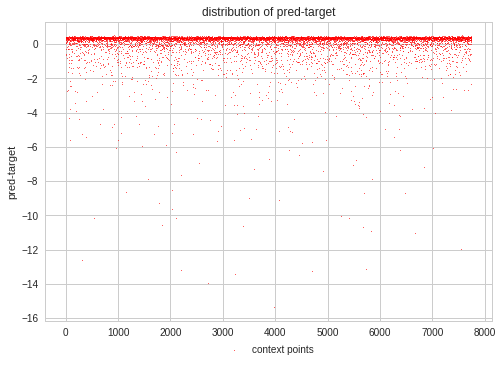

[[ 0.06098252]
 [ 0.00490751]
 [-0.03505169]
 ...
 [-0.01397417]
 [-0.0056404 ]
 [ 0.00070807]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 22/100, loss: 2.669


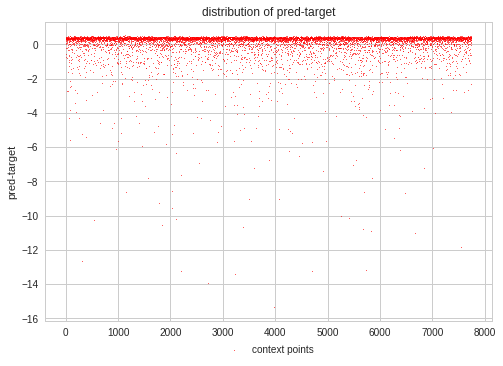

[[ 0.01241797]
 [-0.0735232 ]
 [-0.00411035]
 ...
 [-0.00739409]
 [-0.03422931]
 [-0.01728097]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 23/100, loss: 2.667


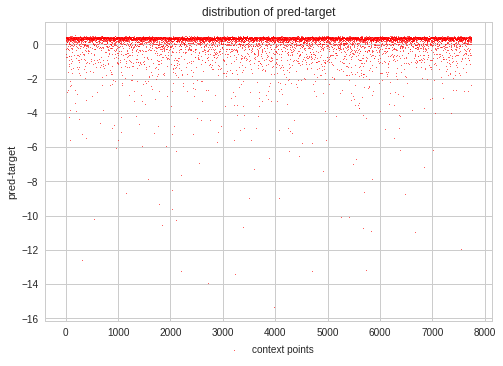

[[-0.04443461]
 [ 0.04535434]
 [-0.04919598]
 ...
 [ 0.00249418]
 [-0.04237586]
 [ 0.0132291 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 24/100, loss: 2.621


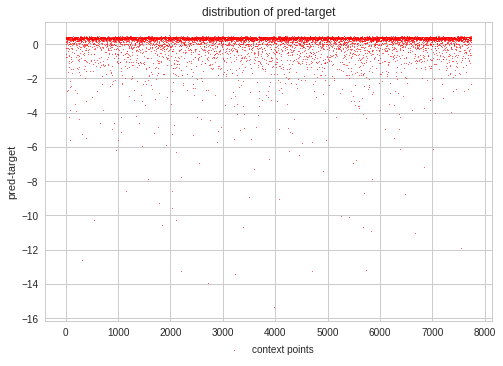

[[ 0.0020564 ]
 [ 0.04653315]
 [ 0.04422625]
 ...
 [-0.01495962]
 [-0.00966183]
 [-0.04259389]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 25/100, loss: 2.608


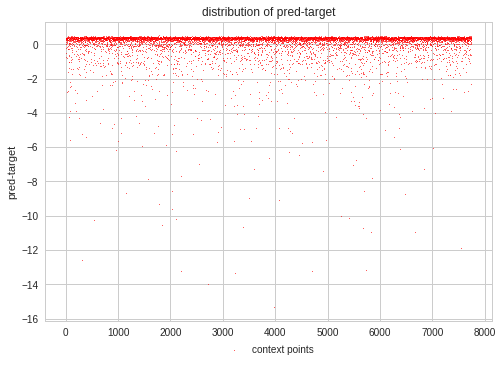

[[-0.00460077]
 [-0.0053416 ]
 [ 0.00358263]
 ...
 [-0.00166759]
 [ 0.01524609]
 [-0.0343347 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 26/100, loss: 2.605


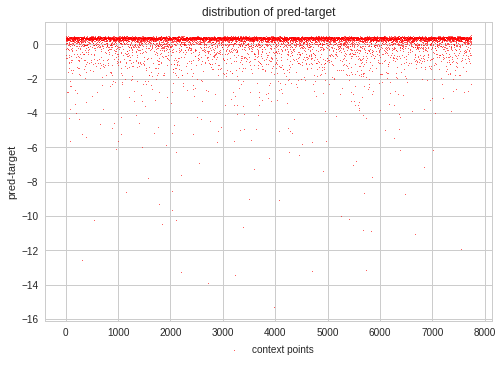

[[-0.04924911]
 [ 0.00205745]
 [-0.03656163]
 ...
 [-0.06323899]
 [-0.01001851]
 [-0.00543923]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 27/100, loss: 2.638


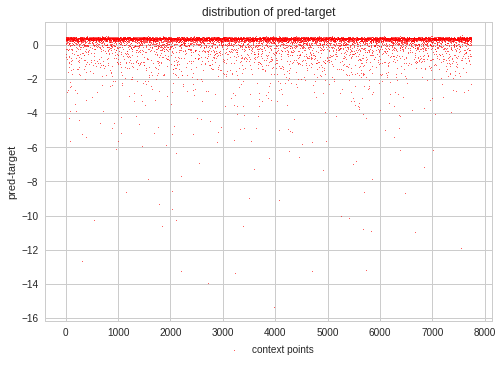

[[-0.00675754]
 [ 0.01835798]
 [ 0.00247944]
 ...
 [-0.01599032]
 [ 0.03552017]
 [-0.01525709]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 28/100, loss: 2.599


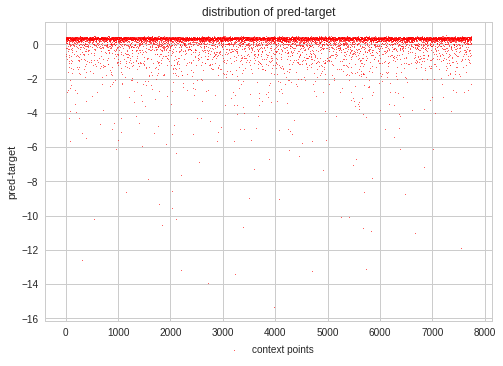

[[-0.04676413]
 [ 0.01464379]
 [ 0.0192976 ]
 ...
 [ 0.00182215]
 [ 0.01618088]
 [ 0.02970853]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 29/100, loss: 2.543


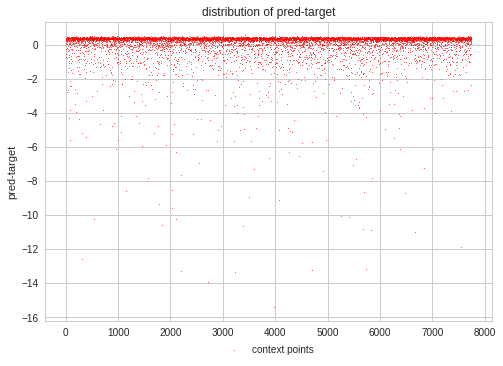

[[-0.05175314]
 [-0.00348424]
 [-0.0421054 ]
 ...
 [-0.03429458]
 [ 0.0117612 ]
 [-0.00329615]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 30/100, loss: 2.543


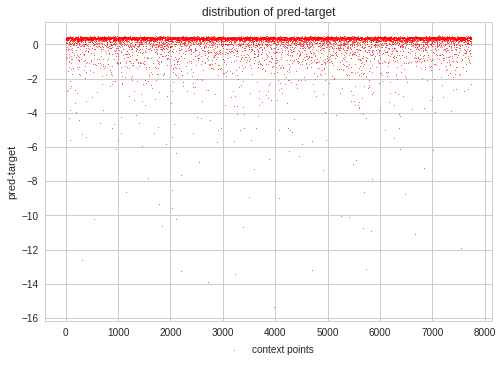

[[-0.01535341]
 [-0.0493924 ]
 [-0.02767038]
 ...
 [-0.08071574]
 [ 0.01300806]
 [-0.00677328]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 31/100, loss: 2.519


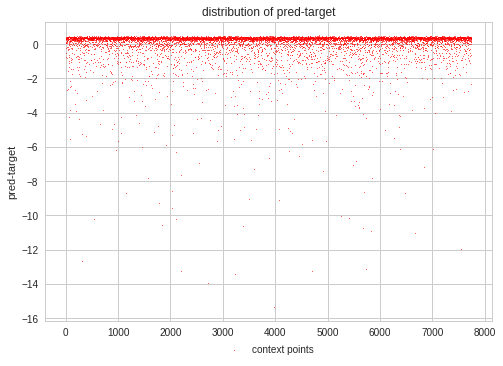

[[-0.043487  ]
 [-0.0319152 ]
 [ 0.02053236]
 ...
 [-0.03489872]
 [-0.04870714]
 [-0.05089724]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 32/100, loss: 2.490


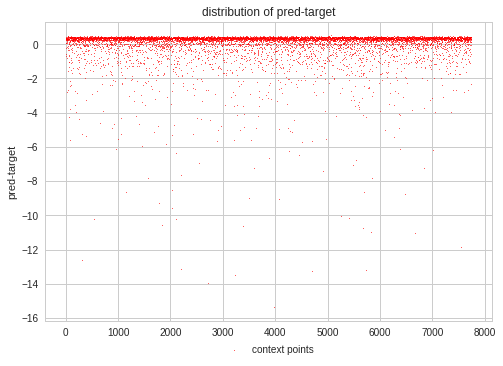

[[-0.00536225]
 [-0.02200044]
 [ 0.02870137]
 ...
 [ 0.00625764]
 [ 0.00853375]
 [-0.00944512]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 33/100, loss: 2.540


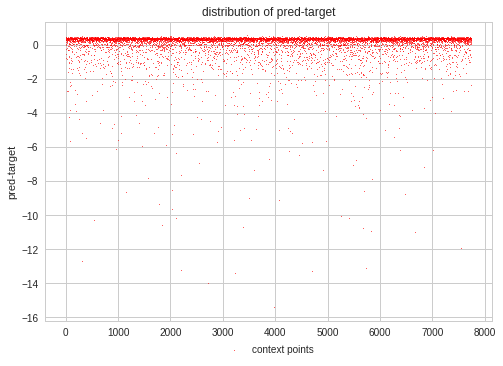

[[-0.04483217]
 [ 0.00071541]
 [ 0.01146583]
 ...
 [-0.01497228]
 [-0.04816199]
 [-0.02175145]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 34/100, loss: 2.465


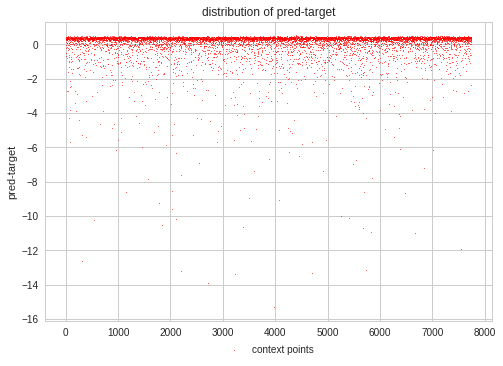

[[ 0.0111887 ]
 [-0.05415008]
 [-0.00392796]
 ...
 [ 0.05222793]
 [-0.0111636 ]
 [ 0.00064063]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 35/100, loss: 2.488


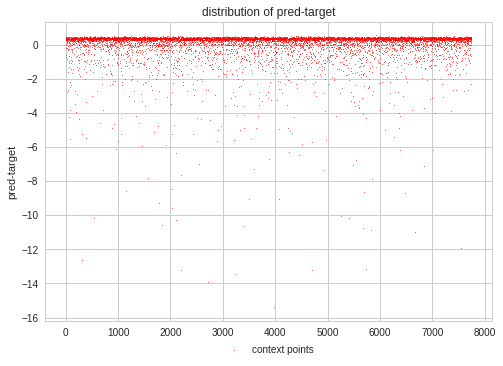

[[-0.02244171]
 [ 0.01885568]
 [ 0.01562164]
 ...
 [-0.01362225]
 [ 0.01177816]
 [-0.0100258 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 36/100, loss: 2.433


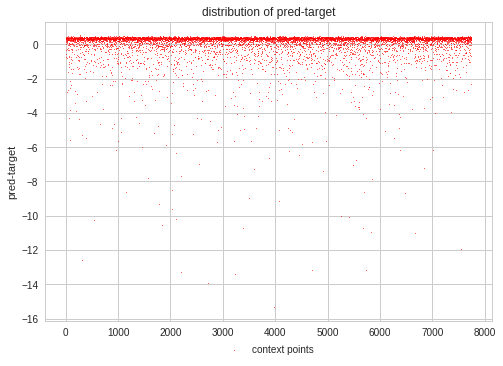

[[-0.07411034]
 [-0.03821017]
 [-0.06156216]
 ...
 [ 0.03212207]
 [-0.02414064]
 [-0.0103846 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 37/100, loss: 2.427


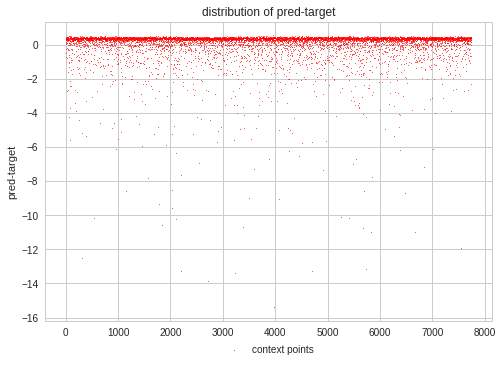

[[-0.00627629]
 [-0.0701379 ]
 [-0.01373096]
 ...
 [-0.00230472]
 [ 0.00509111]
 [ 0.02614149]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 38/100, loss: 2.439


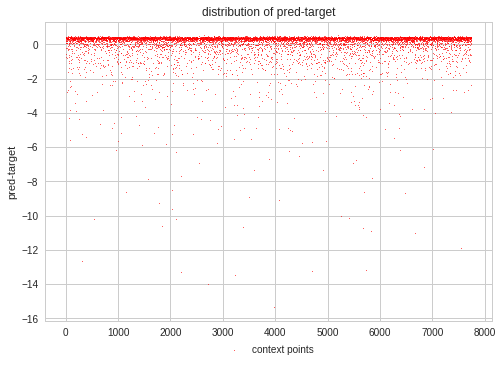

[[-0.05503767]
 [ 0.01498623]
 [ 0.01559468]
 ...
 [-0.0036779 ]
 [-0.00548873]
 [-0.02290684]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 39/100, loss: 2.414


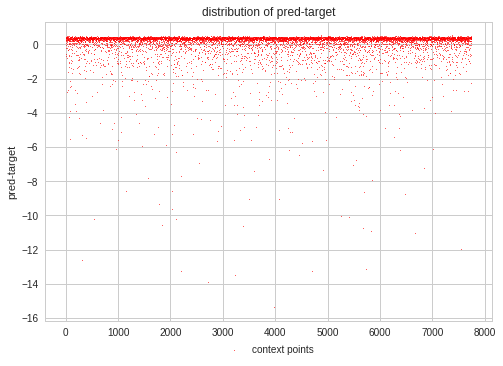

[[-0.03102964]
 [-0.00154415]
 [-0.00062645]
 ...
 [-0.02464189]
 [ 0.0095554 ]
 [ 0.00746713]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 40/100, loss: 2.422


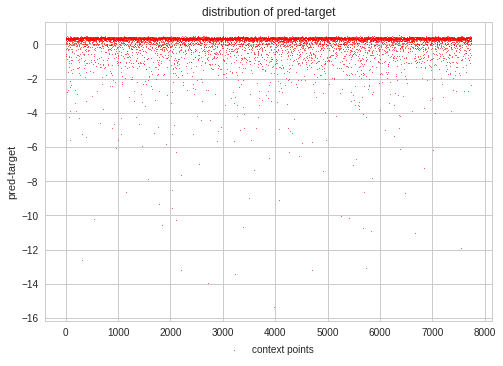

[[-0.02281438]
 [ 0.00832304]
 [-0.0128496 ]
 ...
 [-0.05105156]
 [ 0.02767121]
 [-0.00237547]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 41/100, loss: 2.368


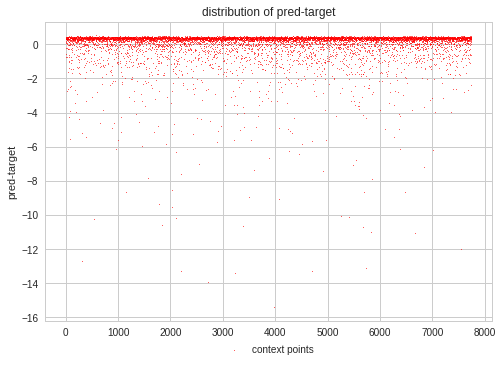

[[ 0.01002374]
 [ 0.01702735]
 [ 0.0033064 ]
 ...
 [-0.02151755]
 [ 0.01794649]
 [ 0.03315055]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 42/100, loss: 2.377


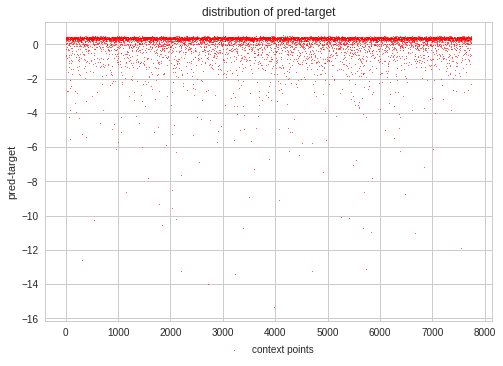

[[ 0.08006243]
 [-0.00529766]
 [-0.02346443]
 ...
 [ 0.0148851 ]
 [ 0.05788948]
 [ 0.02029112]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 43/100, loss: 2.319


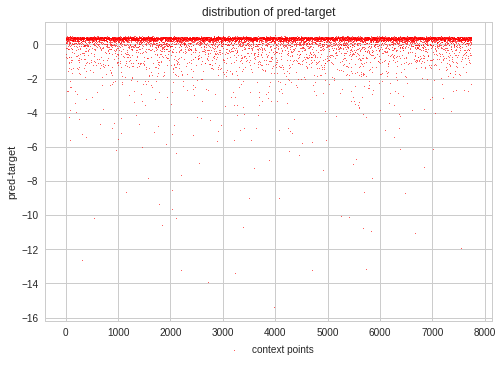

[[-0.00788873]
 [-0.0164528 ]
 [ 0.01878541]
 ...
 [ 0.04063405]
 [-0.04887237]
 [ 0.01283966]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 44/100, loss: 2.312


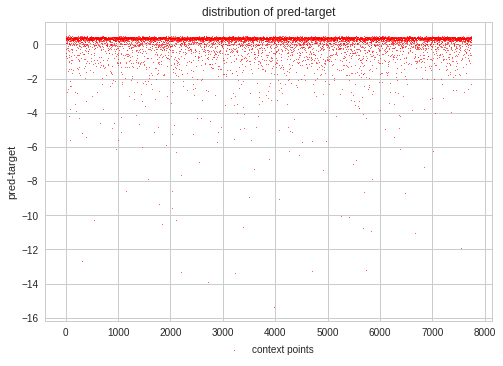

[[ 0.01658811]
 [ 0.00362688]
 [-0.01782498]
 ...
 [ 0.01623056]
 [ 0.00893342]
 [ 0.04339243]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 45/100, loss: 2.307


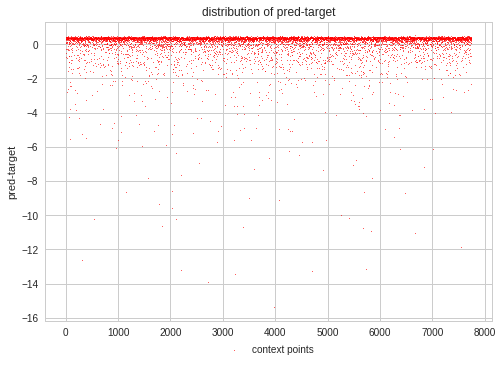

[[-0.00841888]
 [ 0.02403028]
 [-0.02310652]
 ...
 [ 0.00568988]
 [-0.02517478]
 [-0.00839524]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 46/100, loss: 2.326


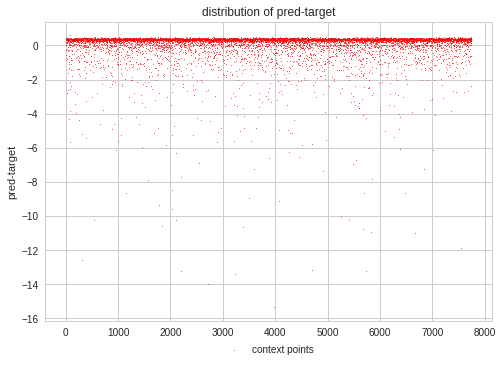

[[ 0.02109201]
 [-0.02306467]
 [-0.03350297]
 ...
 [ 0.02971639]
 [ 0.01757442]
 [-0.03596215]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 47/100, loss: 2.291


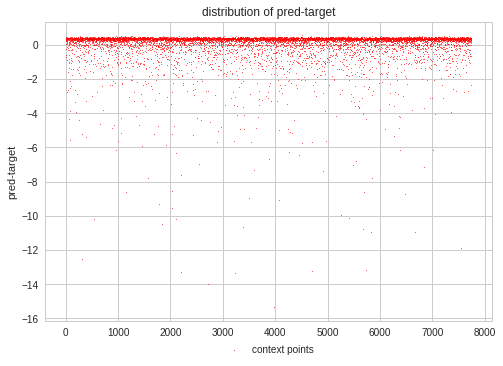

[[ 0.00095363]
 [-0.01987804]
 [-0.00770168]
 ...
 [ 0.0413872 ]
 [-0.00209908]
 [-0.07347807]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 48/100, loss: 2.267


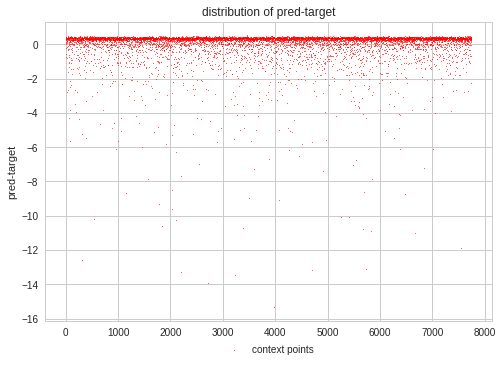

[[-0.01474227]
 [ 0.02162214]
 [ 0.02018784]
 ...
 [ 0.04691957]
 [-0.05087532]
 [-0.00962034]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 49/100, loss: 2.249


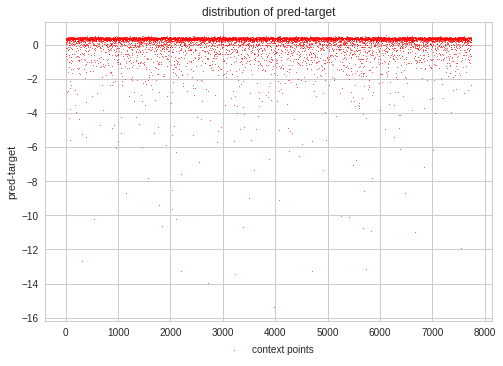

[[ 0.05976268]
 [-0.01598623]
 [ 0.01676404]
 ...
 [ 0.0001844 ]
 [ 0.02161939]
 [-0.02065537]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 50/100, loss: 2.238


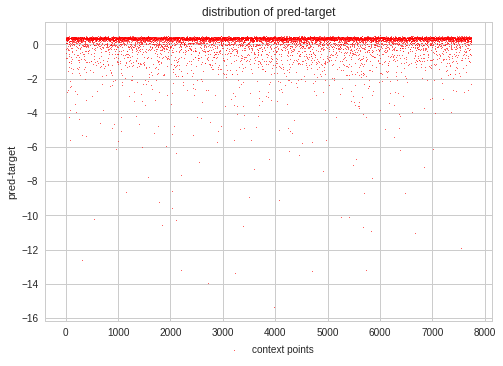

[[-0.01565162]
 [-0.06374202]
 [-0.0145901 ]
 ...
 [-0.03665497]
 [-0.05269636]
 [-0.03091919]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 51/100, loss: 2.242


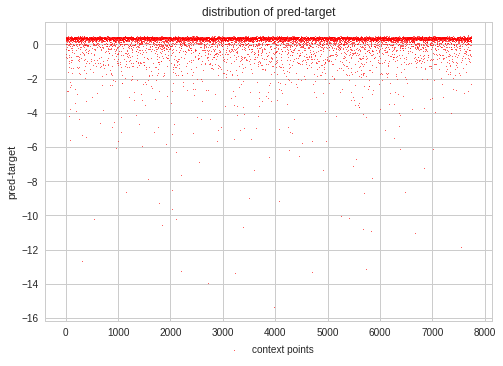

[[-0.02584077]
 [-0.03121934]
 [-0.03675819]
 ...
 [-0.02923431]
 [-0.07430143]
 [ 0.05722389]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 52/100, loss: 2.241


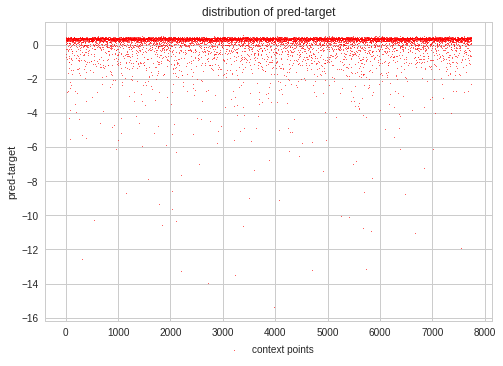

[[-0.02366175]
 [ 0.00134397]
 [-0.00333905]
 ...
 [ 0.00215214]
 [ 0.00015331]
 [-0.03165973]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 53/100, loss: 2.212


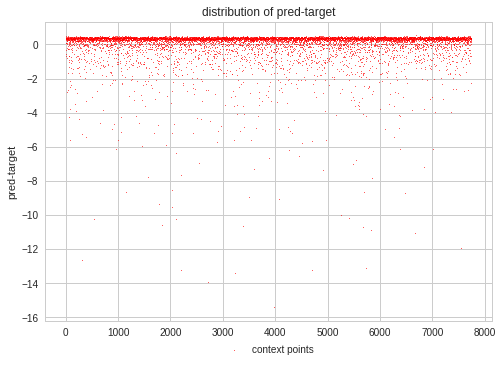

[[-0.00880644]
 [-0.03444573]
 [-0.07895202]
 ...
 [-0.00105741]
 [-0.04995973]
 [-0.03735442]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 54/100, loss: 2.223


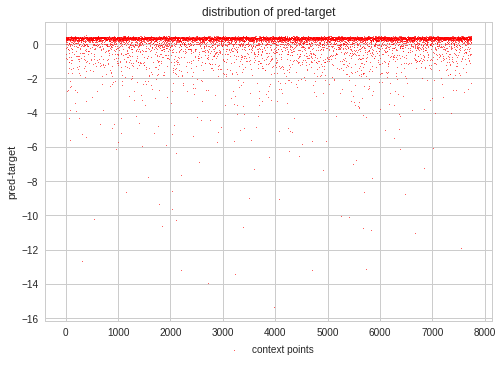

[[ 0.01841941]
 [-0.03719016]
 [ 0.02652779]
 ...
 [-0.00046255]
 [-0.00926976]
 [ 0.03819558]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 55/100, loss: 2.177


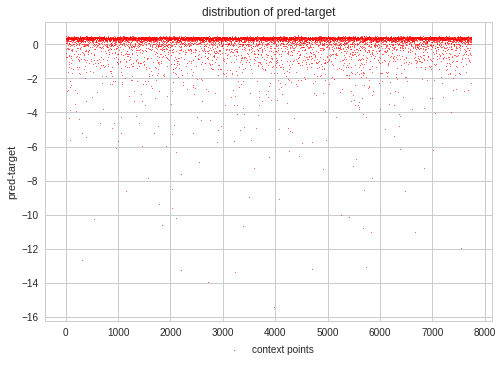

[[ 0.02953181]
 [-0.03262332]
 [-0.05609047]
 ...
 [ 0.00054589]
 [ 0.00088565]
 [-0.02046462]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 56/100, loss: 2.152


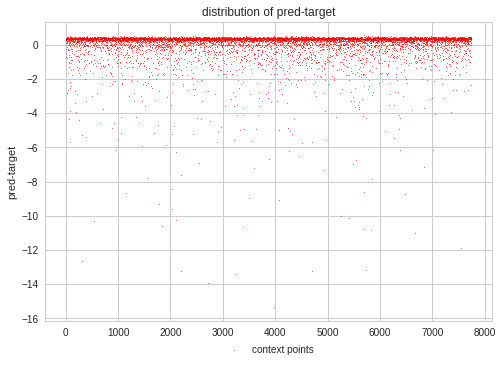

[[-0.04917879]
 [-0.05628663]
 [-0.00536189]
 ...
 [ 0.02724945]
 [-0.01736545]
 [-0.02343892]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 57/100, loss: 2.163


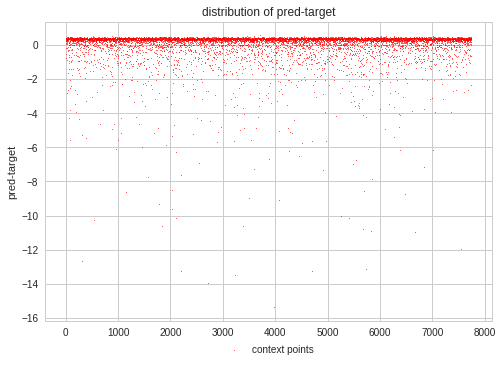

[[-0.04091919]
 [ 0.03495622]
 [ 0.05061858]
 ...
 [-0.08995081]
 [-0.01238324]
 [ 0.03888573]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 58/100, loss: 2.172


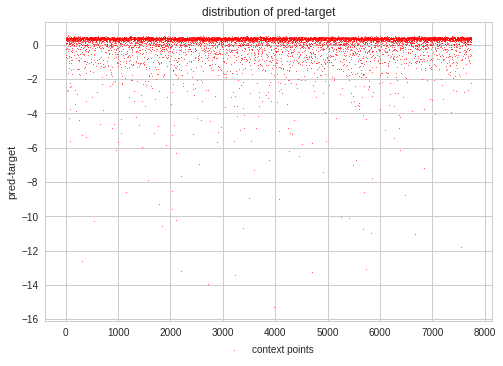

[[-0.04767349]
 [ 0.01141622]
 [-0.0251163 ]
 ...
 [ 0.01468439]
 [ 0.04662852]
 [-0.02287404]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 59/100, loss: 2.121


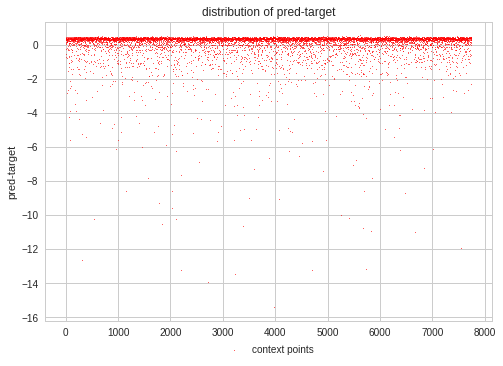

[[ 0.0179135 ]
 [ 0.0342397 ]
 [-0.04393264]
 ...
 [ 0.02136304]
 [ 0.04226946]
 [ 0.00913511]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 60/100, loss: 2.114


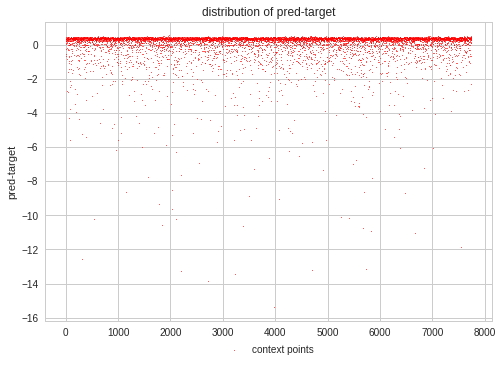

[[-0.08127639]
 [-0.03893028]
 [-0.00125181]
 ...
 [ 0.01344366]
 [ 0.04818628]
 [ 0.00922737]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 61/100, loss: 2.124


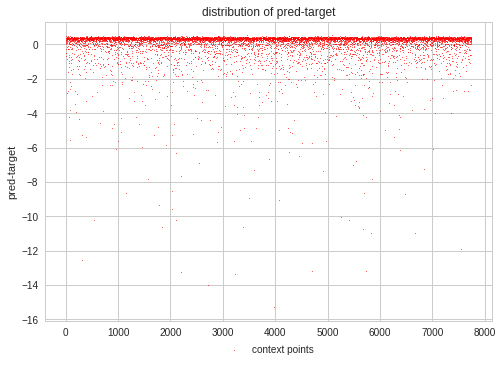

[[ 0.06714115]
 [-0.00543144]
 [-0.02514584]
 ...
 [ 0.02224838]
 [-0.00427351]
 [-0.05339101]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 62/100, loss: 2.141


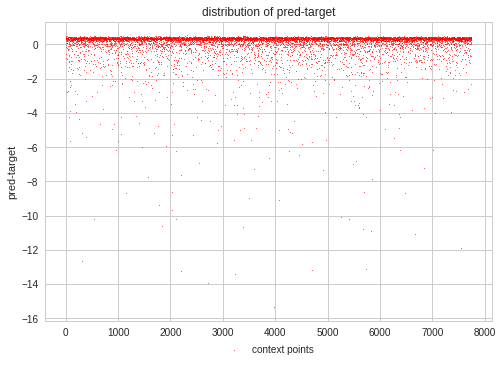

[[-0.01384922]
 [-0.01482879]
 [ 0.07110272]
 ...
 [-0.00097989]
 [ 0.00033573]
 [-0.02194977]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 63/100, loss: 2.085


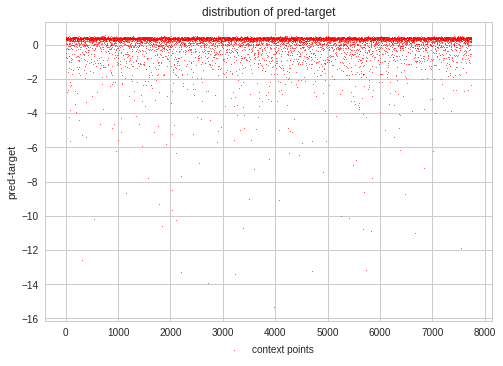

[[ 0.02319722]
 [ 0.00832181]
 [ 0.00156077]
 ...
 [-0.04470828]
 [-0.00509113]
 [-0.06027268]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 64/100, loss: 2.104


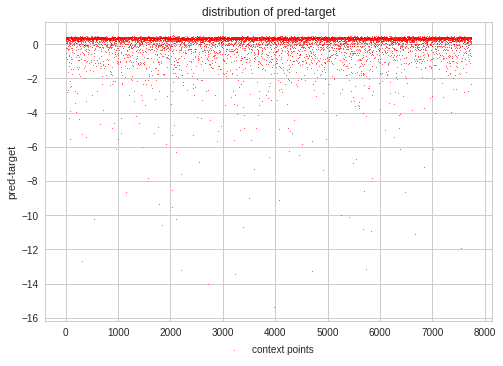

[[-0.01863665]
 [-0.05390617]
 [ 0.00711483]
 ...
 [-0.02064114]
 [-0.00477844]
 [-0.02705495]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 65/100, loss: 2.100


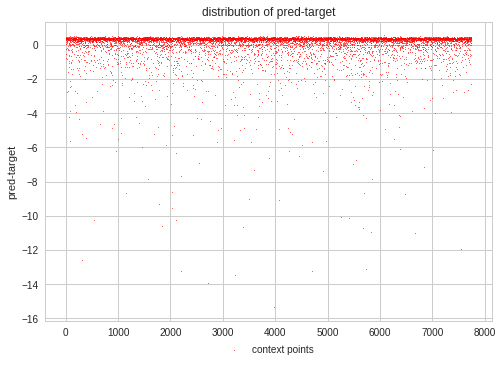

[[ 0.02356781]
 [ 0.00874229]
 [-0.0289884 ]
 ...
 [-0.00450206]
 [-0.00630706]
 [-0.0535839 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 66/100, loss: 2.053


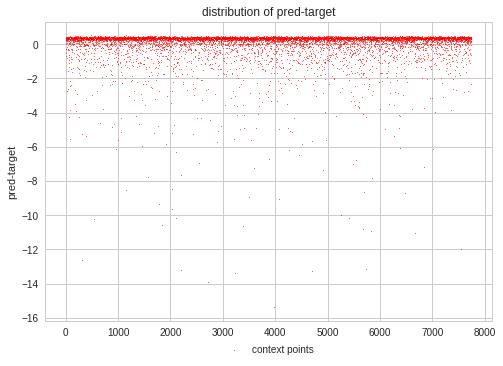

[[-0.01481229]
 [-0.0555029 ]
 [-0.02863901]
 ...
 [-0.05244259]
 [-0.01585372]
 [-0.01384309]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 67/100, loss: 2.073


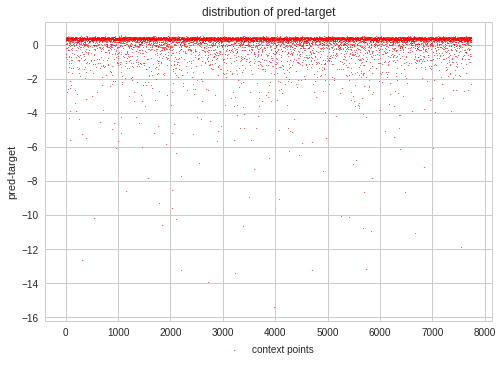

[[-0.020342  ]
 [ 0.01214994]
 [ 0.06095612]
 ...
 [ 0.00939334]
 [ 0.04780583]
 [ 0.03035018]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 68/100, loss: 2.056


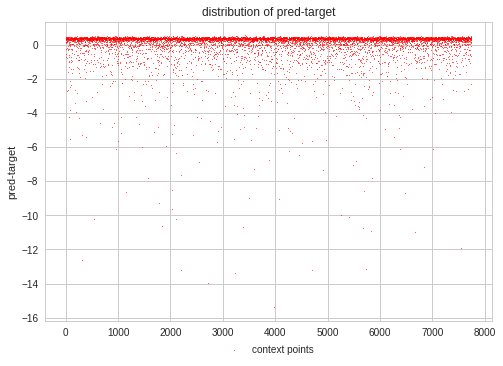

[[ 0.04101994]
 [-0.11091021]
 [-0.03450356]
 ...
 [-0.07541935]
 [ 0.00200676]
 [ 0.05266096]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 69/100, loss: 2.049


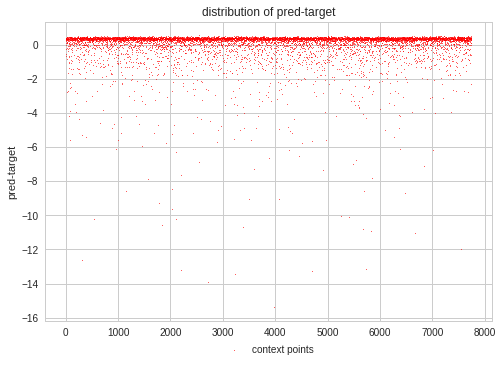

[[ 0.00579084]
 [-0.06965252]
 [-0.01229831]
 ...
 [ 0.00486354]
 [-0.00836286]
 [ 0.10516183]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 70/100, loss: 2.013


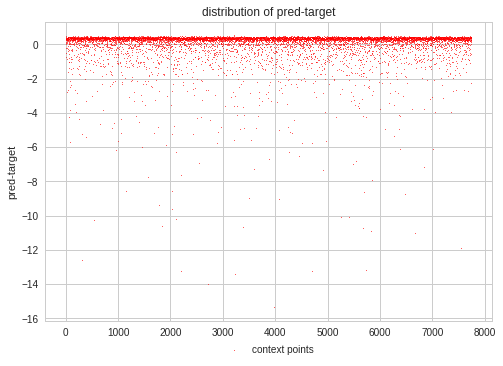

[[-0.03332876]
 [-0.05075793]
 [ 0.00213921]
 ...
 [ 0.03999613]
 [ 0.03636983]
 [-0.00844749]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 71/100, loss: 1.999


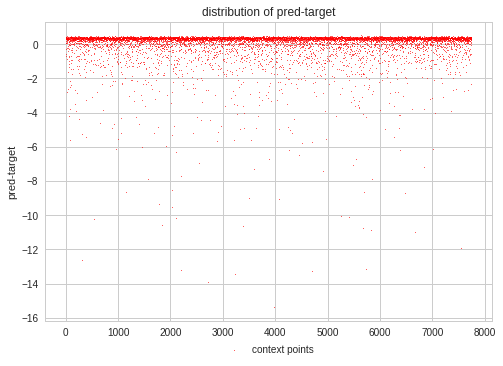

[[ 0.04037004]
 [ 0.0417053 ]
 [-0.01911161]
 ...
 [ 0.03555037]
 [-0.05489364]
 [-0.02743797]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 72/100, loss: 2.007


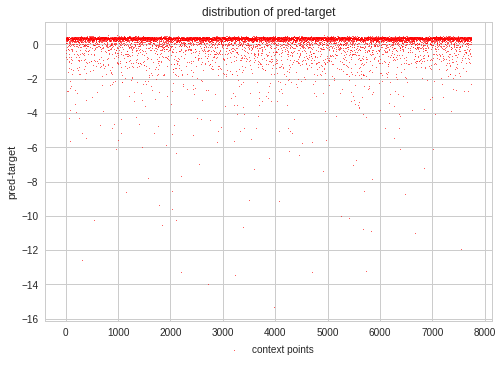

[[-0.04224635]
 [-0.00323724]
 [-0.07597239]
 ...
 [ 0.01373564]
 [-0.01756889]
 [-0.04623199]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 73/100, loss: 1.984


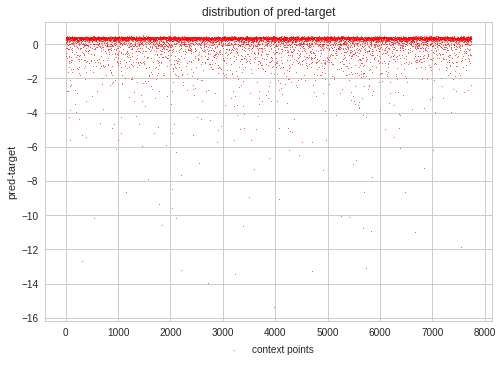

[[-0.03889813]
 [ 0.02936443]
 [-0.00984622]
 ...
 [-0.06648871]
 [ 0.04327288]
 [-0.02404685]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 74/100, loss: 1.979


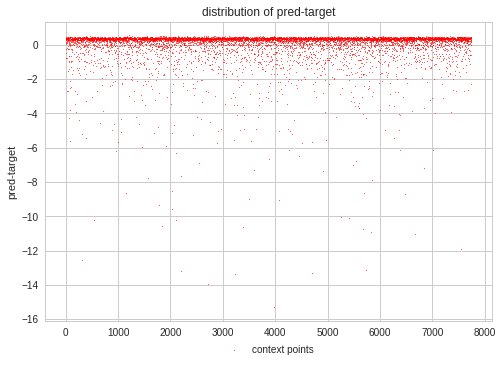

[[-0.03857773]
 [ 0.00586685]
 [-0.0420272 ]
 ...
 [-0.04767141]
 [-0.04402164]
 [ 0.05135685]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 75/100, loss: 1.974


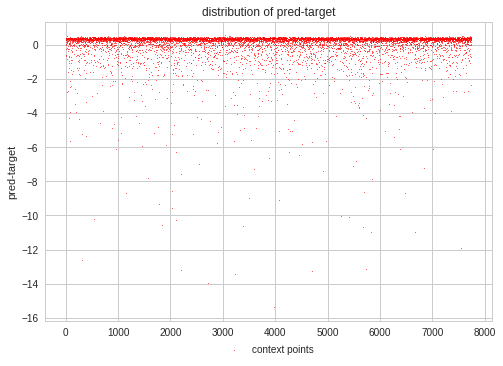

[[-0.04581536]
 [ 0.01533175]
 [-0.02733066]
 ...
 [ 0.0216153 ]
 [-0.03420964]
 [ 0.04131401]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 76/100, loss: 1.955


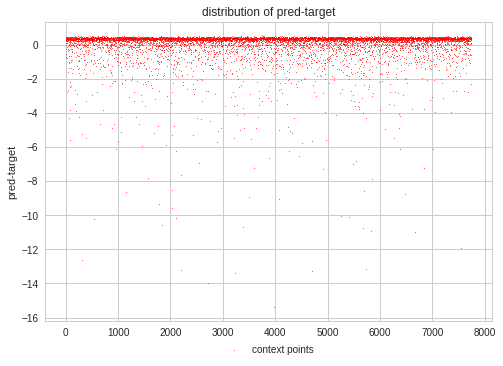

[[-0.03283898]
 [-0.00788977]
 [-0.02058524]
 ...
 [ 0.0717278 ]
 [-0.02397963]
 [ 0.01782984]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 77/100, loss: 1.929


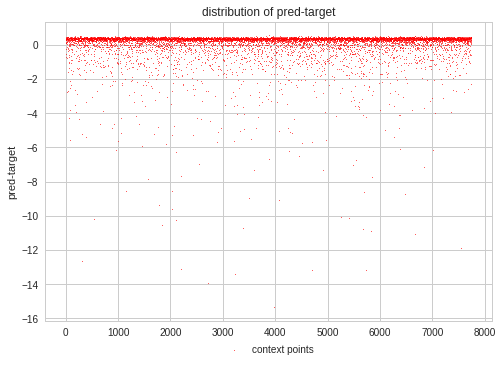

[[-0.0207364 ]
 [ 0.01173504]
 [-0.02963901]
 ...
 [-0.04235636]
 [ 0.00680065]
 [ 0.00285748]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 78/100, loss: 1.933


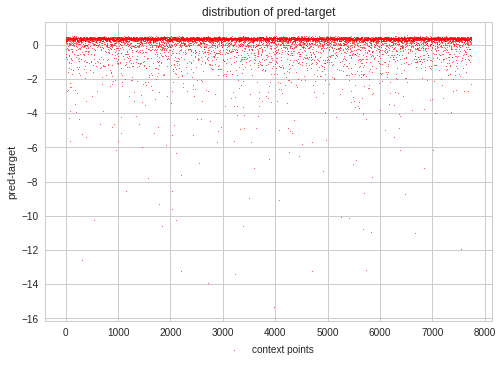

[[-0.00519107]
 [-0.05486194]
 [-0.04264833]
 ...
 [ 0.00216846]
 [ 0.0282533 ]
 [-0.00401838]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 79/100, loss: 1.929


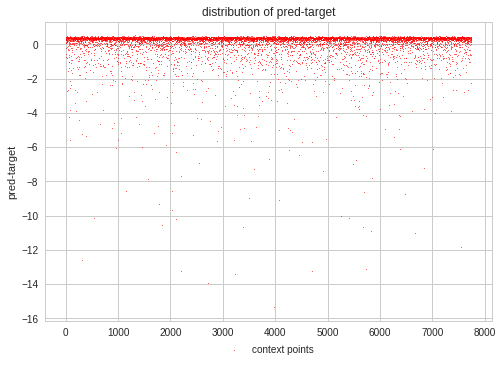

[[-0.04677187]
 [ 0.02792505]
 [ 0.02626762]
 ...
 [ 0.00019785]
 [ 0.01020043]
 [-0.01152004]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 80/100, loss: 1.887


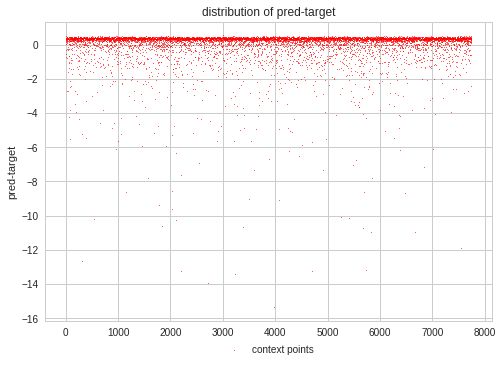

[[-0.04194788]
 [-0.00072068]
 [-0.08621132]
 ...
 [-0.03365793]
 [-0.0230124 ]
 [ 0.02036663]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 81/100, loss: 1.910


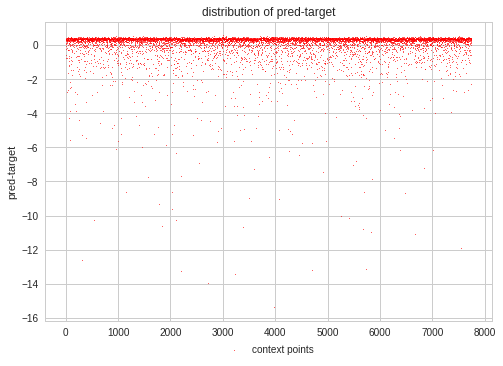

[[-0.00389704]
 [-0.04678691]
 [-0.01319279]
 ...
 [ 0.02102874]
 [-0.06009784]
 [-0.0088079 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 82/100, loss: 1.883


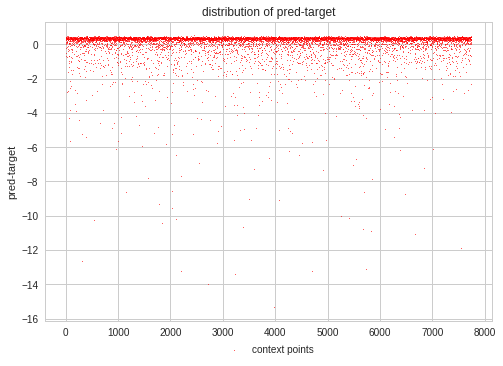

[[-0.0240757 ]
 [ 0.03134991]
 [ 0.01909764]
 ...
 [ 0.00507682]
 [-0.01738682]
 [-0.00452727]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 83/100, loss: 1.881


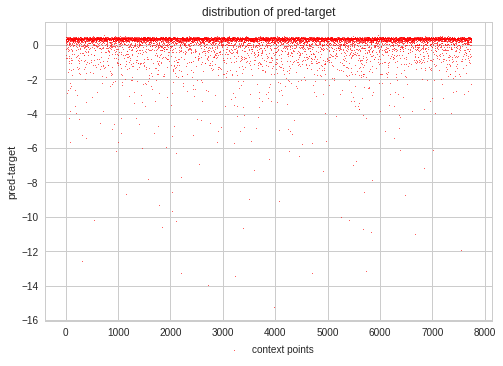

[[ 0.01275987]
 [-0.08267058]
 [ 0.00892059]
 ...
 [ 0.0482595 ]
 [-0.02341837]
 [-0.02888996]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 84/100, loss: 1.869


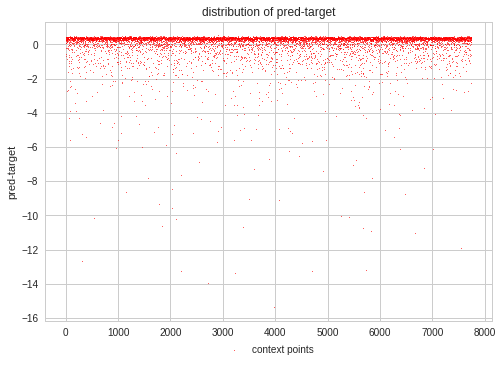

[[-0.02600446]
 [ 0.0267687 ]
 [ 0.01496235]
 ...
 [ 0.02333599]
 [ 0.0083396 ]
 [ 0.03452464]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 85/100, loss: 1.854


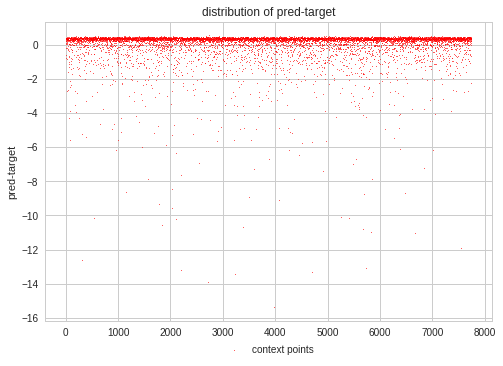

[[ 0.01165636]
 [ 0.00907066]
 [ 0.02703783]
 ...
 [-0.04625009]
 [-0.00698708]
 [-0.00774146]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 86/100, loss: 1.843


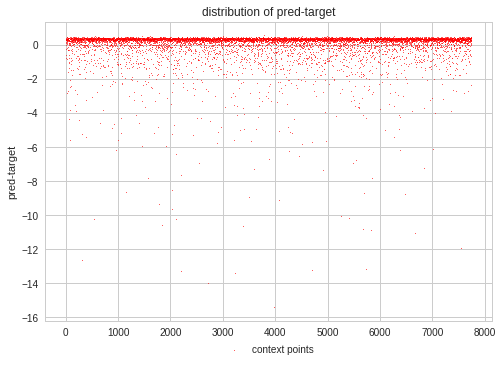

[[ 0.08685876]
 [-0.06555252]
 [-0.01756904]
 ...
 [ 0.06020533]
 [-0.01282125]
 [-0.02769363]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 87/100, loss: 1.837


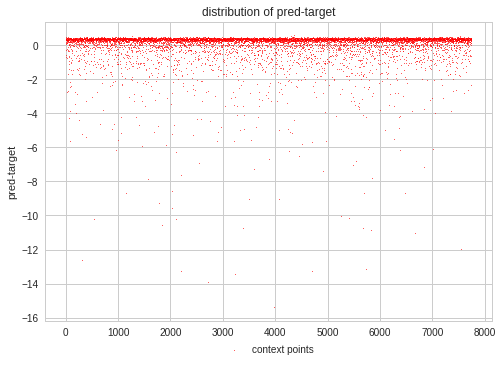

[[ 0.02806009]
 [-0.03830519]
 [-0.02488087]
 ...
 [-0.01257   ]
 [-0.0410704 ]
 [-0.03084557]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 88/100, loss: 1.833


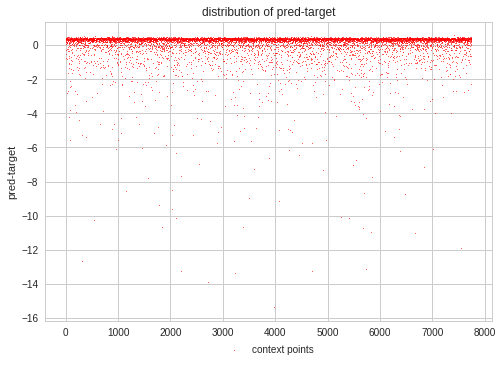

[[-0.05285266]
 [ 0.06411082]
 [-0.0354753 ]
 ...
 [ 0.01616358]
 [-0.01137049]
 [-0.01973839]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 89/100, loss: 1.826


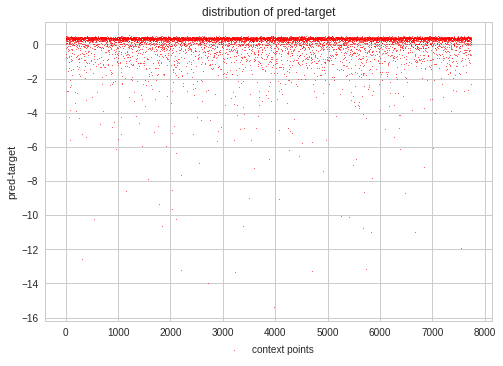

[[-0.03178539]
 [ 0.01477285]
 [ 0.00819085]
 ...
 [ 0.02462654]
 [-0.04033259]
 [ 0.00236668]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 90/100, loss: 1.826


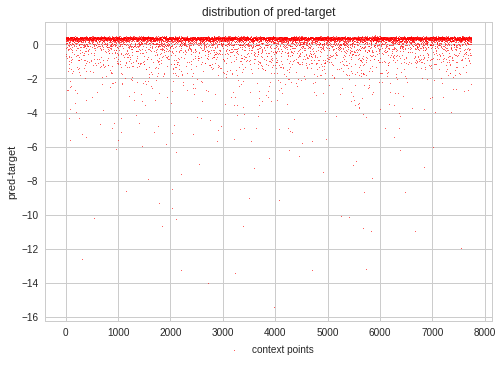

[[ 0.02374145]
 [-0.01520805]
 [ 0.03655977]
 ...
 [-0.03271736]
 [-0.05865062]
 [-0.04459443]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 91/100, loss: 1.789


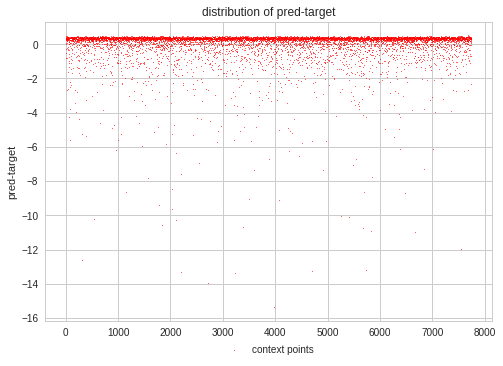

[[-0.06553876]
 [ 0.01458309]
 [-0.02267671]
 ...
 [-0.02313838]
 [-0.03951421]
 [-0.03809188]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 92/100, loss: 1.810


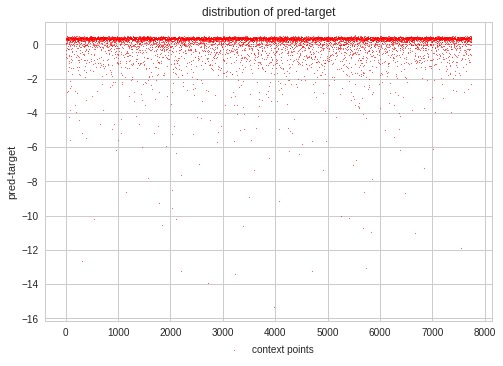

[[ 0.00905483]
 [-0.0100182 ]
 [-0.06759753]
 ...
 [-0.01740711]
 [-0.01174517]
 [ 0.01222794]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 93/100, loss: 1.783


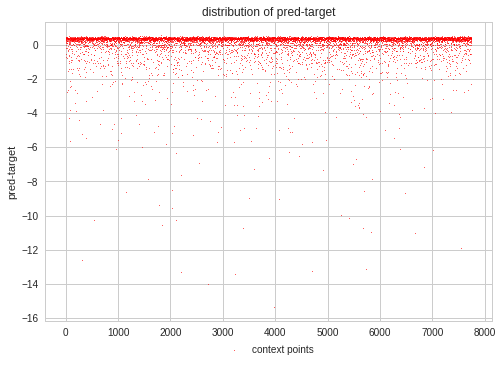

[[ 0.0056512 ]
 [ 0.03728738]
 [ 0.00919757]
 ...
 [-0.02677142]
 [ 0.01822476]
 [-0.0276639 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 94/100, loss: 1.748


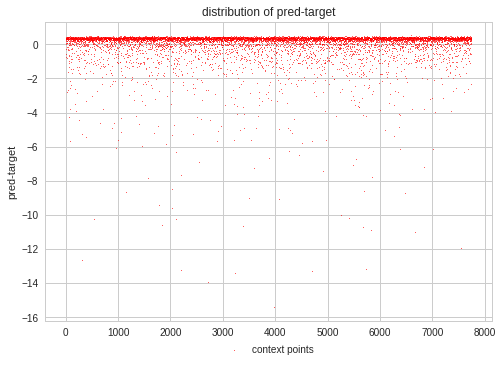

[[-0.07342383]
 [ 0.01036224]
 [-0.00891448]
 ...
 [-0.00567296]
 [ 0.02051567]
 [-0.0146276 ]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 95/100, loss: 1.750


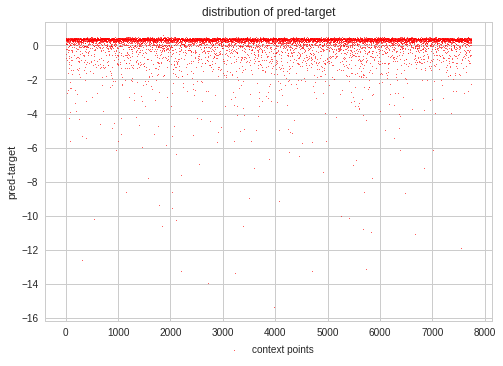

[[-0.00157043]
 [ 0.05950942]
 [ 0.00552003]
 ...
 [-0.03872788]
 [ 0.0328809 ]
 [-0.02361936]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 96/100, loss: 1.727


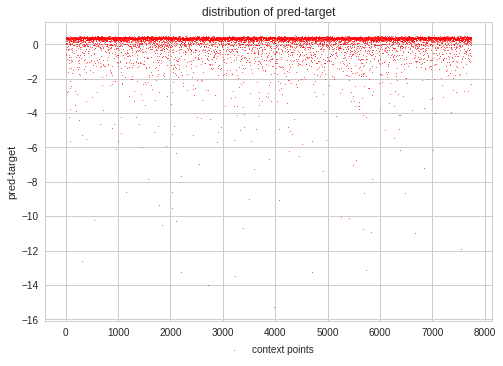

[[-0.01184424]
 [-0.03584339]
 [-0.04977376]
 ...
 [-0.016645  ]
 [ 0.02287351]
 [-0.02466762]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 97/100, loss: 1.735


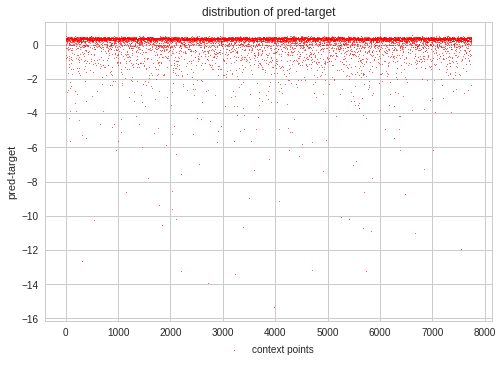

[[-0.02886513]
 [ 0.11061801]
 [ 0.02886946]
 ...
 [-0.01425149]
 [-0.02154515]
 [ 0.02298536]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 98/100, loss: 1.726


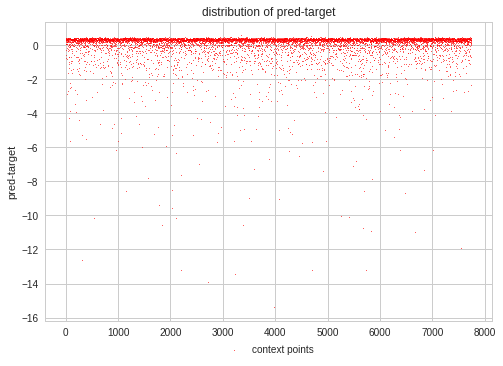

[[-0.00420589]
 [ 0.03313155]
 [-0.05585817]
 ...
 [-0.07178244]
 [-0.00637936]
 [-0.00618499]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Epoch 99/100, loss: 1.716


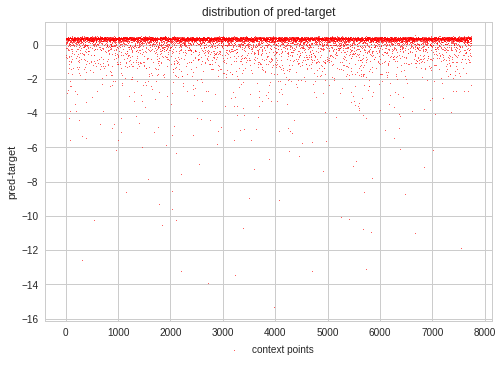

[[ 0.06170269]
 [-0.06635389]
 [ 0.02472253]
 ...
 [ 0.0264392 ]
 [-0.05100087]
 [-0.02615515]]
tensor([[-0.3012],
        [-0.3811],
        [ 0.2357],
        ...,
        [-0.2435],
        [-0.4210],
        [-0.4246]])
Done.


In [0]:
stdx, stdy = StandardScaler().fit(train_norm_x), StandardScaler().fit(train_norm_y)
X, y = stdx.transform(train_norm_x), stdy.transform(train_norm_y)
idx = np.arange(X.shape[0])

idxR = np.random.choice(idx, size=(5000,), replace=False)

idxM = np.array([i for i in idx if i not in idxR.tolist()])

XR, yR = torch.from_numpy(X[idxR].astype(np.float32)), torch.from_numpy(y[idxR].astype(np.float32))
XM, yM = torch.from_numpy(X[idxM].astype(np.float32)), torch.from_numpy(y[idxM].astype(np.float32))
X, y = torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32))

torch.manual_seed(5)
# We need to increase the free bits for this model to prevent U dominating Z
fnp_plus = RegressionFNP(dim_x=41, dim_y=1, transf_y=stdy, dim_h=100, dim_u=3, n_layers=1, 
                         num_M=XM.size(0), dim_z=50, fb_z=3.0, use_plus=True)

if torch.cuda.is_available():
    XR, XM, X = XR.cuda(), XM.cuda(), X.cuda()
    yR, yM, y = yR.cuda(), yM.cuda(), y.cuda()
    fnp_plus = fnp_plus.cuda()

optimizer = Adam(fnp_plus.parameters(), lr=1e-4, weight_decay=0.)
fnp_plus.train()


epochs = 100
for i in range(epochs):
    optimizer.zero_grad()
    
    loss = fnp_plus(XR, yR, XM, yM)
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(model11.parameters(), 1.)
    optimizer.step()
    
#     new_fb = - (fb_init / ep_e) * i + fb_init * (1. + (ep_s / ep_e))    
#     model11.fb = min(fb_init, max(new_fb, 0))
        
    if i % int(epochs / 100) == 0:
        print('Epoch {}/{}, loss: {:.3f}'.format(i, epochs, loss.item()))
        new_y = fnp_plus.predict(XM, XR, yR)

        s_con = plt.scatter(np.arange(new_y.shape[0]), new_y-yM.cpu().numpy(),color='red',s=0.3,label='context points')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
        plt.xlabel('')
        plt.ylabel('pred-target')
        plt.title(r'distribution of pred-target')
        plt.show()
        print(new_y)
        print(yM.cpu())
print('Done.')

In [0]:
print(new_y)
print(yM.cpu())

[[-0.00536725]
 [-0.02591841]
 [-0.01137302]
 ...
 [-0.01195371]
 [-0.0243319 ]
 [-0.02048968]]
tensor([[-0.3012],
        [-0.3811],
        [-0.3323],
        ...,
        [-0.2435],
        [-0.2258],
        [-0.4246]])


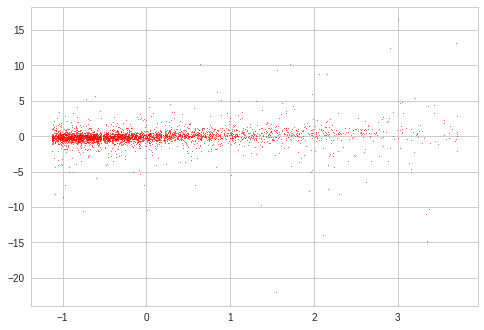

In [0]:
plt.scatter(yM.cpu().numpy(), new_y,color='red',s=0.3,label='context points')